In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()


True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")


LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


기본 PDF 기반 Retrieval Chain 생성

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


/Users/hyunoozzing/Project/llm/langchain/CH17/rag/base.py:33: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  return OllamaEmbeddings(model="nomic-embed-text")


In [4]:
search_result = pdf_retriever.invoke("앤스로픽에 투자한 기업과 투자금액을 알려주세요.")
search_result

[Document(id='54aa2fae-99b1-4ae5-abfe-b87c87b7192e', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 2, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='Ⅰ\n. 인공지능 산업 동향 브리프'),
 Document(id='30ef5ef9-7488-47f6-9d26-1fd8226ee4af', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 5, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='수립과 테스트 수행을 주도할 영국 AI 안전 연구소의 출범을 발표\n∙ 첨단 AI 모델의 안전 테스트는 국가 안보와 안전, 사회적 피해를 포함한 여러 잠재적 유해 기능에 대한\n시험을 포함하며, 참석자들은 정부 주도의 외부 안전 테스트에 합의\n∙ 각국 정부는 테스트와 기타 안전 연구를 위한 공공부문 역량에 투자하고, 테스트 

In [5]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요.",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)


KeyboardInterrupt: 

State 정의

State: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 TypedDict 형식을 사용합니다.

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)


노드(Node) 정의

Nodes: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
참고

State를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다.


In [7]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


Edges

Edges: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [8]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)


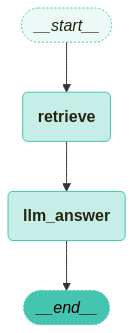

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

그래프 실행

- config 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- recursion_limit: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- inputs: 그래프 실행 시 필요한 입력 정보를 전달합니다.

참고
- 메시지 출력 스트리밍은 LangGraph 스트리밍 모드의 모든 것 을 참고해주세요.
- 아래의 stream_graph 함수는 특정 노드만 스트리밍 출력하는 함수입니다.
- 손쉽게 특정 노드의 스트리밍 출력을 확인할 수 있습니다.

In [10]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽에 투자한 기업과 투자금액을 알려주세요.")

# 그래프 실행
stream_graph(app, inputs, config, ["llm_answer"])


KeyboardInterrupt: 

In [ ]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')